# <center> Themes and schemantics

The aim of this exploration is:
 - **Topic 1:** Wordcloud des mots les plus fréquents dans les captions gagnantes vs. celles les moins drôles
 - 
 - 
 - 

# Initialisation –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

Importing the necessary stuff

In [1]:
# Text analysis
import re
import string
from collections import Counter
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer  # <== use this instead

# Text visualisiation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Statistical modeling
import statsmodels.api as sm


nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

tokenizer = TreebankWordTokenizer()

In [2]:
import sys
sys.path.append("..")   # path *relative* to your notebook
from DataPreparation import dataA, dataC

dataA[0].head()  # first 5 rows

DataPreparation variables exported successfully.


,caption,mean,precision,votes,not_funny,somewhat_funny,funny
rank,,,,,,,
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6


# Topic 1 –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

<p style="text-align: center;"><em>Wordcloud des mots les plus fréquents dans les captions gagnantes vs. celles les moins drôles</em></p>

Aim of this topic:
 - Find most frequent words in winning captions: limit search in the beginning to top 100 comments
 - Find most frequent words in Least funny captions: This could be done by looking at the final 1000 comments.

A conceptual question arises. Do we simply work with ranking, higher rank meaning less funny? Or do we introduce a funniness score:
$$
\text{Funniness\_score} = \frac{\omega_1\cdot\text{funny} + \omega_2\cdot\text{somewhat\_funny} + \omega_3 \cdot\text{not\_funny}}{\text{number\_of\_votes}}
$$
I will conduct both analyses. For the weights, I will introduce a linear model to learn how the funniness is actually decided.

In [3]:
# I will make the rank a new column, not an index
dfs_fixed = []
for i, d in enumerate(dataA):
    d = d.reset_index()
    d['contest_id'] = i + 510  # contests start at 510
    dfs_fixed.append(d)

combinedA = pd.concat(dfs_fixed, ignore_index=True)

# Normalising ranking to [0,1]
combinedA['rank_norm'] = combinedA.groupby('contest_id')['rank'].transform(lambda r: r / r.max())

combinedA['p_funny'] = combinedA['funny'] / combinedA['votes']
combinedA['p_somewhat'] = combinedA['somewhat_funny'] / combinedA['votes']
combinedA['p_not'] = combinedA['not_funny'] / combinedA['votes']

X = combinedA[['p_funny', 'p_somewhat', 'p_not']]
y = combinedA['rank_norm']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

w1, w2, w3 = -model.params['p_funny'], -model.params['p_somewhat'], -model.params['p_not']
weights = [w / sum([w1, w2, w3]) for w in [w1, w2, w3]]
print("Normalised weights:", weights)

                            OLS Regression Results                            
Dep. Variable:              rank_norm   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                 1.558e+06
Date:                Sat, 11 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:13:39   Log-Likelihood:             8.6905e+05
No. Observations:             2292678   AIC:                        -1.738e+06
Df Residuals:                 2292674   BIC:                        -1.738e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6020      0.103     -5.843      0.0

The results are promising and make sense intuitively. We found that the having more funny votes will lead to a better rank (lower rank value) and same for somewhat funny. This is seen by the negative coefficient "p\_funny" and "p\_somewhat". The weights in the funniness score are then inversed, since we will define funnier as higher funniness score. We allow negative funniness: thats when there are many more not funny votes than funny votes.

In [4]:
# Add a funniness score to the dataframes
dataA1 = dataA.copy()
for d in dataA1:
    d['funniness_score'] = (weights[0] * d['funny'] + weights[1] * d['somewhat_funny'] + weights[2] * d['not_funny']) / d['votes']

In [5]:
# Basic list of common English stopwords (can be expanded) -> necessary since nltk stopwords is bugging
STOPWORDS = {
    # --- pronouns and determiners ---
    "i","me","my","myself","we","our","ours","ourselves","you","your","yours",
    "yourself","yourselves","he","him","his","himself","she","her","hers","herself",
    "it","its","itself","they","them","their","theirs","themselves","us",
    "what","which","who","whom","this","that","these","those",
    
    # --- auxiliary verbs & modals ---
    "am","is","are","was","were","be","been","being","have","has","had","having",
    "do","does","did","doing","can","could","will","would","shall","should","may",
    "might","must","ought",
    
    # --- articles, prepositions, conjunctions ---
    "a","an","the","and","but","if","or","because","as","until","while","of","at",
    "by","for","with","about","against","between","into","through","during","before",
    "after","above","below","to","from","up","down","in","out","on","off","over",
    "under","again","further","then","once","here","there","when","where","why",
    "how","all","any","both","each","few","more","most","other","some","such","no",
    "nor","not","only","own","same","so","than","too","very","s","t","now","just",
    
    # --- contractions & spoken forms ---
    "im","ive","id","youre","youve","youd","hes","shes","theyre","theyve","weve",
    "wed","dont","doesnt","didnt","cant","couldnt","wont","wouldnt","shouldnt",
    "isnt","arent","wasnt","werent","thats","theres","whats","whos","hows","lets",
    "re","don","ill", "ll","d","ve","y","ma",
    
    # --- generic filler verbs & expressions ---
    "get","got","getting","go","goes","going","gone","see","saw","seen","say",
    "says","said","make","makes","made","know","knows","knew","think","thinks",
    "thought","need","needs","needed","want","wants","wanted","like","likes",
    "liked","use","used","using","try","trying","tried","work","works","worked",
    "take","takes","took","put","puts","doing","done","give","gives","gave",
    
    # --- discourse fillers ---
    "well","really","one","even","still","lot","thats","thing","things","way",
    "something","anything","everything","nothing","time","back","new","also",
    "ever","always","maybe"
}


# Now, we can do the word frequency analysis on dataA1
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    # lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # regex tokenise (words of length ≥2)
    tokens = re.findall(r'\b[a-z]{2,}\b', text)
    # remove stopwords
    tokens = [t for t in tokens if t not in STOPWORDS]
    return tokens

We now tokenize our text. This will allow us to count occurences of words easily.

In [6]:
dataA2 = dataA1.copy()
# applying the tokenization and cleaning function to the captions
# This adds a new column 'tokens' to each dataframe in dataA1
for d in dataA2:
    d['tokens'] = d['caption'].apply(preprocess_text)

# Takes around 30 secs

List of most common words that are not in the stopwords list

In [7]:
# Combining all tokens from all dataframes
all_tokens = []
for d in dataA2:
    all_tokens.extend([word for tokens in d['tokens'] for word in tokens])

# Count word frequencies
word_counts = Counter(all_tokens)

print(word_counts.most_common(20))

[('look', 40345), ('told', 38502), ('good', 37717), ('right', 36730), ('sorry', 35736), ('never', 31405), ('tell', 31360), ('little', 30948), ('sure', 29617), ('next', 29541), ('last', 29407), ('yes', 29157), ('first', 27599), ('let', 26235), ('looks', 24902), ('better', 24838), ('feel', 24778), ('come', 24664), ('much', 24077), ('oh', 23889)]


Now, let us count the most common words in the top 100 comments, and do the same for the last 1000 comments.

In [8]:
# Count word frequencies in top 100 and bottom 1000 comments. BASED ON FUNNINESS SCORE
top_100_tokens = []
bottom_1000_tokens = []
for d in dataA2:
    top_100 = d.nlargest(100, 'funniness_score')
    bottom_1000 = d.nsmallest(1000, 'funniness_score')
    top_100_tokens.extend([word for tokens in top_100['tokens'] for word in tokens])
    bottom_1000_tokens.extend([word for tokens in bottom_1000['tokens'] for word in tokens])

top_100_counts = Counter(top_100_tokens)
bottom_1000_counts = Counter(bottom_1000_tokens)


In [9]:
# Some stuff
print("Top 20 words in top 100 comments:", top_100_counts.most_common(20))
print("Top 20 words in bottom 1000 comments:", bottom_1000_counts.most_common(20))

# find words that appear in top 100 but not in bottom 1000
unique_top_words = set(top_100_counts) - set(bottom_1000_counts)
print("Words in top 100 but not in bottom 1000:", unique_top_words)

# find words that appear in top 100 but not in bottom 1000, but only those that appear at least 3 times in top 100
unique_top_words_5 = {word for word in unique_top_words if top_100_counts[word] >= 3}
print("Words in top 100 but not in bottom 1000 (at least 3 occurrences):", unique_top_words_5)

Top 20 words in top 100 comments: [('look', 740), ('right', 685), ('good', 664), ('first', 600), ('last', 590), ('tell', 555), ('never', 554), ('let', 540), ('yes', 528), ('sorry', 486), ('sure', 483), ('little', 460), ('next', 449), ('told', 449), ('call', 445), ('come', 416), ('looks', 402), ('home', 390), ('much', 385), ('better', 370)]
Top 20 words in bottom 1000 comments: [('told', 7020), ('look', 6701), ('sorry', 6564), ('good', 6331), ('right', 6314), ('never', 5228), ('little', 5208), ('next', 5113), ('tell', 5071), ('sure', 4998), ('last', 4783), ('come', 4592), ('oh', 4481), ('yes', 4446), ('let', 4432), ('much', 4332), ('first', 4295), ('better', 4245), ('looks', 4113), ('please', 4094)]
Words in top 100 but not in bottom 1000: {'worrymr', 'ethicist', 'affront', 'zyzzik', 'toughguy', 'momentright', 'onetofive', 'sustainablysourced', 'onwhats', 'rollerball', 'funnynow', 'luka', 'firesafety', 'certifiedorganic', 'arousals', 'questionwhere', 'reasonthey', 'tunneltotable', 'depo

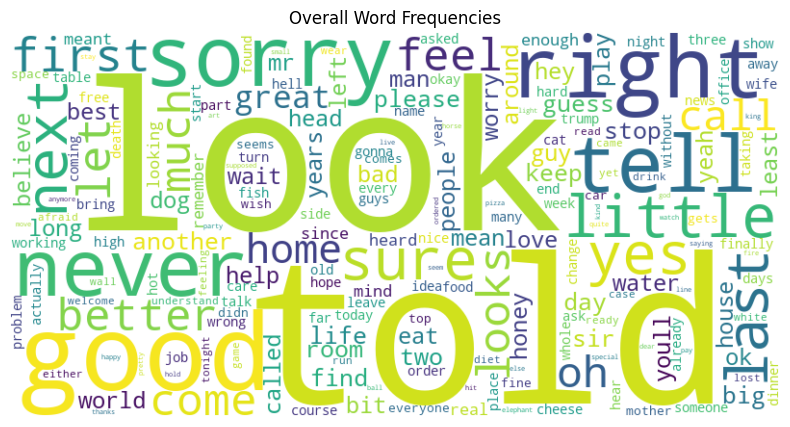

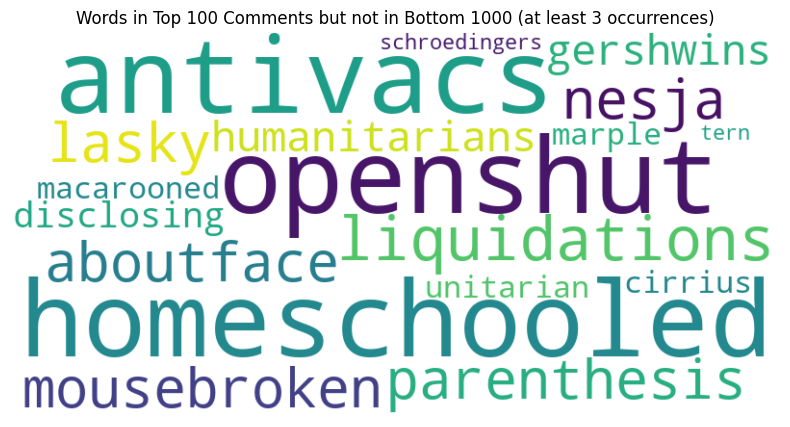

In [10]:
# Visualisation of word frequencies using wordcloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.title('Overall Word Frequencies')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# same for top unique_top_words_5
unique_top_words_5_freq = {word: top_100_counts[word] for word in unique_top_words_5}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unique_top_words_5_freq)
plt.figure(figsize=(10, 5))
plt.title('Words in Top 100 Comments but not in Bottom 1000 (at least 3 occurrences)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Topic 2 –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

<p style="text-align: center;"><em>Fréquence des entités (issues de entities du metadata) dans les captions et leur score moyen.</em></p>

In [11]:
dataC1 = dataC.copy()
dataC1

,num_captions,num_votes,image_locations,image_descriptions,image_uncanny_descriptions,entities,questions,date
0,3905.0,41185.0,[the street],[A man is relaxing on a city street. Others ar...,[A man is just laying in the middle of the sid...,[https://en.wikipedia.org/wiki/Bystander_effec...,[Why is he laying there?],NaT
1,3325.0,28205.0,"[the front hard, a residential walkway]",[A man in a winter coat and cap is looking at ...,[It's unusual to see someone holding a snow sh...,"[https://en.wikipedia.org/wiki/Snowball_fight,...",[Is the man overly small or the shovel overly ...,NaT
2,4399.0,21574.0,"[yoga place, a yoga studio]",[A man and woman are standing facing one anoth...,[Nothing is really out of place in this image....,"[https://en.wikipedia.org/wiki/Rug, https://en...","[Why is the man carrying a huge rug?, Why is t...",2016-03-21
3,4141.0,16894.0,"[a workplace, an elevator]",[Three business men are walking down a hall. T...,[A suit case is usually carried by one person ...,[https://en.wikipedia.org/wiki/Worker_cooperat...,[Why is the briefcase big enough for three peo...,2016-03-27
4,3951.0,95790.0,[plains],[Some cowboys are riding through the desert. T...,[There are rocking horses in place of real hor...,"[https://en.wikipedia.org/wiki/Rocking_horse, ...",[Why is this chase taking place?],2016-04-03
...,...,...,...,...,...,...,...,...
379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


Notice, we know the location of certain images. Count which occurs and how often!

In [12]:
# Counting the locations in the location column


Here, we want to count the number of objects occuring in captions. We also want to somehow see what occurs in the funniest comments, as well as in least funny comments.

In [13]:
%pip install --upgrade nltk
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk import pos_tag, word_tokenize
print(pos_tag(word_tokenize("The cat sat on the mat.")))

def extract_nouns_nltk(entry):
    """Extract nouns whether the entry is a string or a list of strings."""
    if isinstance(entry, list):
        text = " ".join(entry)
    elif isinstance(entry, str):
        text = entry
    else:
        return []

    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)
    nouns = [word for word, pos in tagged if pos.startswith('NN')]
    return nouns

dataC1['nouns'] = dataC1['image_descriptions'].apply(extract_nouns_nltk)
dataC1['uncanny nouns'] = dataC1['image_uncanny_descriptions'].apply(extract_nouns_nltk)
dataC1['questions nouns'] = dataC1['questions'].apply(extract_nouns_nltk)

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\andra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to C:\Users\andra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andra/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


[('The', 'DT'), ('cat', 'NN'), ('sat', 'VBD'), ('on', 'IN'), ('the', 'DT'), ('mat', 'NN'), ('.', '.')]


In [14]:
# Count the occurence of nouns overall
all_nouns = []
for col in ['nouns', 'uncanny nouns', 'questions nouns']:
    all_nouns.extend([word for tokens in dataC1[col] for word in tokens])
noun_counts = Counter(all_nouns)
print("Most common nouns overall:", noun_counts.most_common(1000))
print("Most common nouns in image descriptions:", Counter([word for tokens in dataC1['nouns'] for word in tokens]).most_common(1000))
print("Most common nouns in uncanny descriptions:", Counter([word for tokens in dataC1['uncanny nouns'] for word in tokens]).most_common(1000))
print("Most common nouns in questions:", Counter([word for tokens in dataC1['questions nouns'] for word in tokens]).most_common(1000))

Most common nouns overall: [('man', 494), ('people', 169), ('woman', 147), ('room', 67), ('men', 64), ('office', 59), ('table', 53), ('head', 43), ('couple', 42), ('house', 41), ('person', 39), ('face', 39), ('restaurant', 37), ('doctor', 37), ('dog', 35), ('living', 34), ('king', 33), ('place', 33), ('top', 31), ('waiter', 30), ('front', 29), ('water', 29), ('hair', 29), ('animals', 29), ('bar', 28), ('car', 27), ('fish', 27), ('mountain', 25), ('clothes', 25), ('whale', 24), ('island', 24), ('middle', 24), ('kitchen', 24), ('caveman', 24), ('someone', 23), ('way', 23), ('knight', 22), ('cat', 22), ('boy', 21), ('desert', 21), ('building', 21), ('paper', 21), ('cave', 21), ('dogs', 21), ('bird', 20), ('birds', 20), ('bunch', 20), ('shop', 20), ('piano', 20), ('horse', 20), ('ground', 19), ('couch', 19), ('wall', 19), ('store', 19), ('suit', 19), ('baseball', 19), ('time', 19), ('city', 18), ('door', 18), ('hand', 17), ('window', 17), ('shark', 17), ('food', 17), ('phone', 17), ('earth

So we could count the occurence of nouns overall in all comments. Lets visualise this, maybe after categorising them?

In [15]:
# Some chatGPT suggestions for categories
noun_categories = {
    # People & Professions
    'people': {
        'man','men','woman','women','people','person','couple','boy','girl','lady',
        'husband','wife','king','queen','prince','princess','knight','boss','client',
        'lawyer','judge','doctor','scientist','psychiatrist','therapist','chef','baker',
        'bartender','waiter','waitress','businessman','businesswoman','worker','employee',
        'manager','customer','patron','guard','cop','policeman','officer','soldier','hunter',
        'cowboy','shepherd','priest','god','angel','devil','reaper','mobster','barber',
        'artist','musician','coach','scientist','explorer','astronaut','vendor','teacher',
        'realtor','psychiastrist','hitchhiker','host','usher','attendant','judge','realtor',
        'coach','author','assistant','farmer','rancher'
    },

    # Animals
    'animals': {
        'dog','dogs','cat','cats','bird','birds','fish','whale','whales','shark','sharks',
        'dolphin','dolphins','bear','bears','wolf','wolves','horse','horses','elephant',
        'giraffe','giraffes','lizard','lizards','reptile','dinosaur','dinosaurs','rabbit',
        'sheep','mouse','mice','rat','rats','snail','monkey','monkeys','pigs','ducks','deer',
        'hamster','bull','goat','dragon','dragons','wolf','werewolf','werewolves','yeti',
        'unicorn','centaur','mammoths','alligator','alligators','crocodile','creatures',
        'beast','cowboys','dogs','cats','animal','animals','giraffes','gators'
    },

    # Objects & Everyday Items
    'objects': {
        'table','tables','chair','chairs','desk','desks','suit','suits','clothes','clothing',
        'shirt','jackets','tie','coat','suitcase','briefcase','bag','bags','cup','cups','mug',
        'glass','glasses','bottle','lamp','phone','phones','cellphone','computer','computers',
        'tv','screen','window','windows','door','doors','paper','papers','book','books',
        'clipboard','sign','signs','machine','machines','instrument','instruments','guitar',
        'piano','tuba','drum','pen','pencil','scissors','brush','robe','apron','hat','hats',
        'cap','crown','shoes','boots','socks','uniform','outfit','outfits','gear','costume',
        'costumes','umbrella','lamp','clipboard','bucket','buckets','clock','frame','mirror',
        'rope','chain','cart','box','boxes','board','boards','stool','stools','coat','jackets'
    },

    # Places & Settings
    'places': {
        'room','office','building','buildings','store','shop','restaurant','bar','cafe',
        'court','courtroom','city','street','park','house','houses','home','apartment',
        'museum','castle','workplace','desert','island','mountain','mountains','cave','caves',
        'beach','kitchen','church','elevator','road','forest','woods','gallery','hospital',
        'sidewalk','corner','sky','tower','hall','hallway','block','station','subway','alley',
        'yard','field','ranch','countryside','yard','plains','path','studio','balcony','space'
    },

    # Nature & Environment
    'nature': {
        'earth','ocean','sea','water','air','fire','sand','tree','trees','cactus','cacti',
        'flowers','leaves','grass','snow','rain','cloud','clouds','sun','sky','moon','wind',
        'hill','rock','rocks','ground','soil','planet','planets','mountain','mountains',
        'environment','nature','beach','island','forest','woods','desert'
    },

    # Fantasy, Religion & Myth
    'fantasy': {
        'angel','angels','god','devil','satan','reaper','heaven','hell','ghost','spirit',
        'knight','king','queen','prince','princess','crown','dragon','dragons','genie',
        'centaur','vampire','wizard','magician','myth','throne','castle','werewolf',
        'werewolves','rapunzel','moses','adam','eden','reaper','saint','prophet'
    },

    # Work & Business Contexts
    'work': {
        'office','desk','desks','meeting','business','workers','employee','boss','lawyer',
        'judge','court','courtroom','document','papers','briefcase','chart','presentation',
        'computer','computers','report','file','customer','client','deal','stock','stocks',
        'job','manager','coworker','executives','company','factory','lab','scientist',
        'scientists','workplace','work','employee','employers','meeting','psychiastrist',
        'realtor','clerk','cashier','shop','barber','assistant','vendor','therapist'
    },

    # Food & Dining
    'food': {
        'restaurant','bar','bartender','waiter','waitress','menu','cake','food','drink',
        'drinks','coffee','wine','beer','pizza','soup','sandwich','meat','bowl','plate',
        'table','tables','dinner','lunch','breakfast','chef','baker','oven','kitchen',
        'refrigerator','fridge','cup','mug','spoon','fork','dessert','pie','hotdog','pancake',
        'burger','beer','wine','cocktail','meal','pancakes','soup','cake','beverage'
    },

    # Death, Danger & Conflict
    'death': {
        'death','coffin','coffins','grave','graveyard','cemetery','skull','skeleton','gun',
        'knife','sword','soldier','fight','battle','danger','mobster','corpse','corpses',
        'reaper','devil','hell','coffin','tomb','predator','execution','cemetery','war',
        'blood','crime','murder','death','coffin'
    },

    # Abstract Concepts & Miscellaneous
    'abstract': {
        'time','way','place','look','thing','things','nothing','act','idea','story','scene',
        'piece','shape','situation','reason','life','conversation','thought','love','meeting',
        'discussion','therapy','dream','feeling','design','art','color','expression','pattern',
        'story','music','sound','tone','idea','idea','meaning'
    }
}

def categorise_noun(noun):
    for category, words in noun_categories.items():
        if noun in words:
            return category
    return 'other'
dataC1['category'] = dataC1['nouns'].apply(lambda nouns: [categorise_noun(noun) for noun in nouns])
dataC1['category uncanny'] = dataC1['uncanny nouns'].apply(lambda nouns: [categorise_noun(noun) for noun in nouns])
dataC1['category questions'] = dataC1['questions nouns'].apply(lambda nouns: [categorise_noun(noun) for noun in nouns])

Category counts: Counter({'other': 2631, 'people': 1332, 'places': 647, 'animals': 530, 'objects': 479, 'nature': 229, 'abstract': 206, 'food': 154, 'death': 69, 'work': 66, 'fantasy': 59})


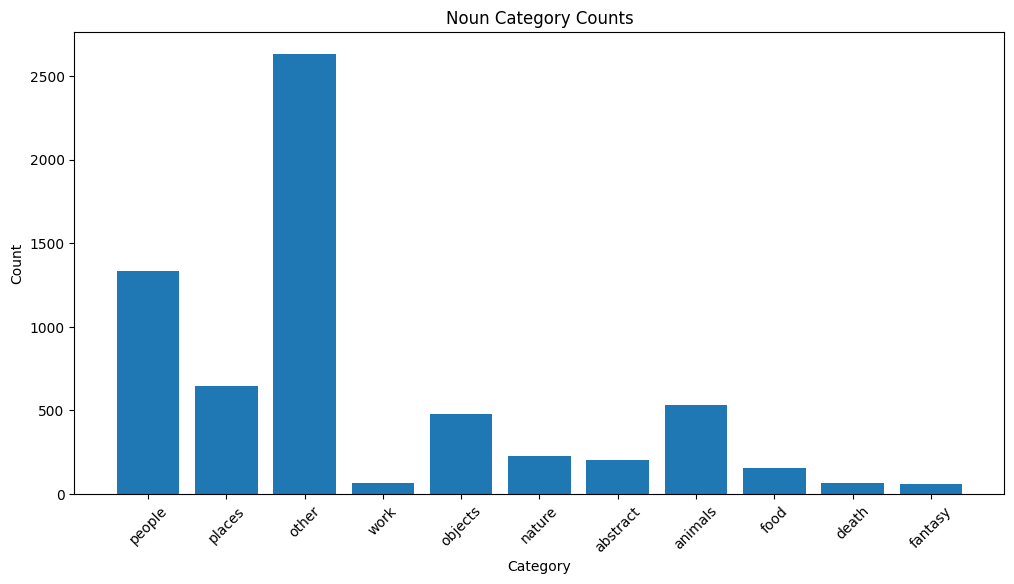

In [16]:
# Lets count the occurrences of each category
category_counts = Counter()
for col in ['category', 'category uncanny', 'category questions']:
    for categories in dataC1[col]:
        category_counts.update(categories)
print("Category counts:", category_counts)

#plotting the category counts
plt.figure(figsize=(12, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xticks(rotation=45)
plt.title('Noun Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


Comparing how often men occur, compared to women

In [17]:
# Women occurence compared to Men
women_words = {'woman', 'women', 'girl', 'girls', 'lady', 'ladies', 'mother', 'mothers', 'daughter', 'daughters', 'sister', 'sisters'}
men_words = {'man', 'men', 'boy', 'boys', 'gentleman', 'gentlemen', 'father', 'fathers', 'son', 'sons', 'brother', 'brothers'}

# Count occurrences of women and men words
women_count = dataC1['nouns'].apply(lambda nouns: sum(1 for noun in nouns if noun in women_words)).sum()
men_count = dataC1['nouns'].apply(lambda nouns: sum(1 for noun in nouns if noun in men_words)).sum()
             
print(f"Fraction of women-related words: {women_count / (women_count+men_count):.2%}")

Fraction of women-related words: 27.66%


I am now interested to make a new dataframe which contains all the comments with female words, and same for male words. I want to see what words appear the most in said captions.

In [31]:

# Sub dataframe with only entries that have women-related words
dataC_women = dataC1[
    dataC1['nouns'].apply(lambda nouns: any(noun in women_words for noun in nouns)) |
    dataC1['uncanny nouns'].apply(lambda nouns: any(noun in women_words for noun in nouns)) |
    dataC1['questions nouns'].apply(lambda nouns: any(noun in women_words for noun in nouns))
]
# Same for men
dataC_men = dataC1[
    dataC1['nouns'].apply(lambda nouns: any(noun in men_words for noun in nouns)) |
    dataC1['uncanny nouns'].apply(lambda nouns: any(noun in men_words for noun in nouns)) |
    dataC1['questions nouns'].apply(lambda nouns: any(noun in men_words for noun in nouns))
]


# Make a count of all nouns that follow women-related words
def count_following_nouns(df, gender_words):
    counter = Counter()
    for noun_list in df['nouns']:
        for i, noun in enumerate(noun_list[:-1]):
            if any(noun.startswith(g) for g in gender_words):
                next_noun = noun_list[i+1]
                counter[next_noun] += 1
    return counter

women_follow_counts = count_following_nouns(dataC_women, women_words)
men_follow_counts   = count_following_nouns(dataC_men, men_words)

# Make a count of all nouns that are before women-related words
def count_preceding_nouns(df, gender_words):
    counter = Counter()
    for noun_list in df['nouns']:
        for i, noun in enumerate(noun_list[1:], start=1):
            if noun in gender_words:
                prev_noun = noun_list[i-1]
                counter[prev_noun] += 1
    return counter

women_preceding_counts = count_preceding_nouns(dataC_women, women_words)
men_preceding_counts   = count_preceding_nouns(dataC_men, men_words)


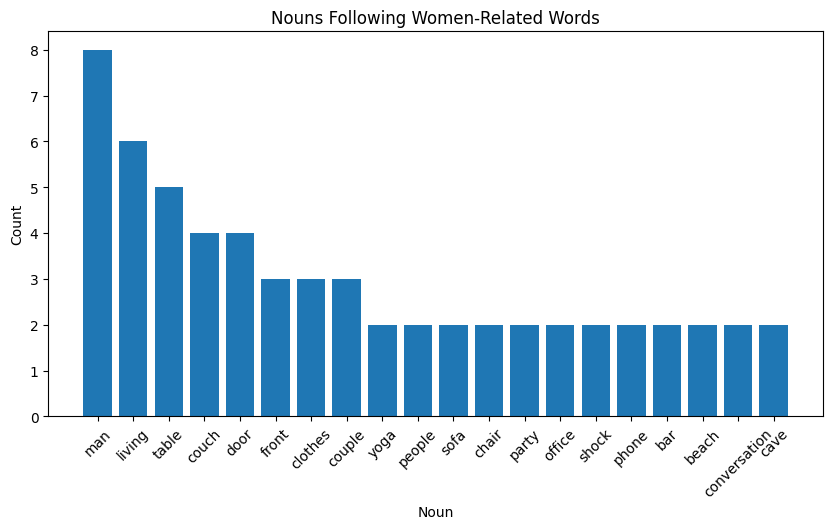

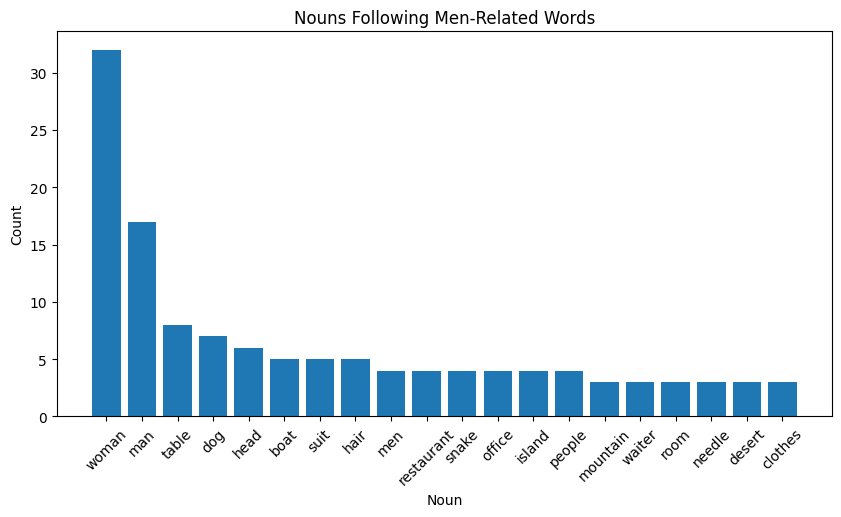

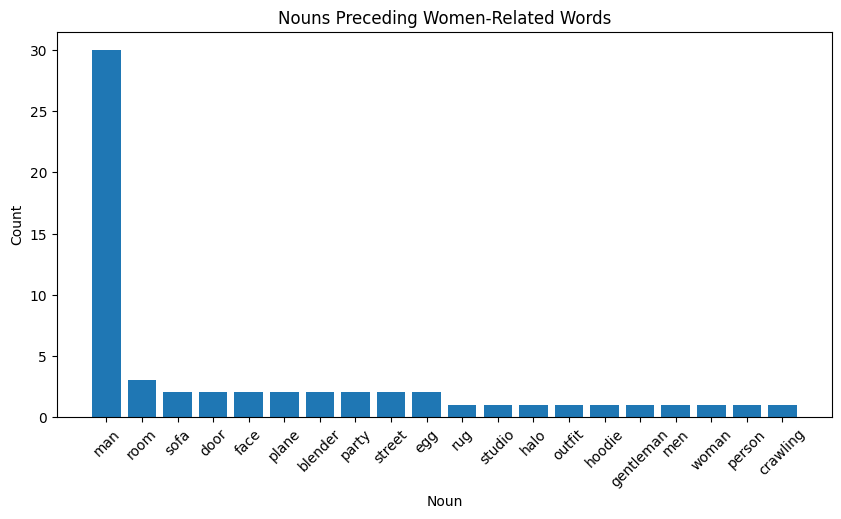

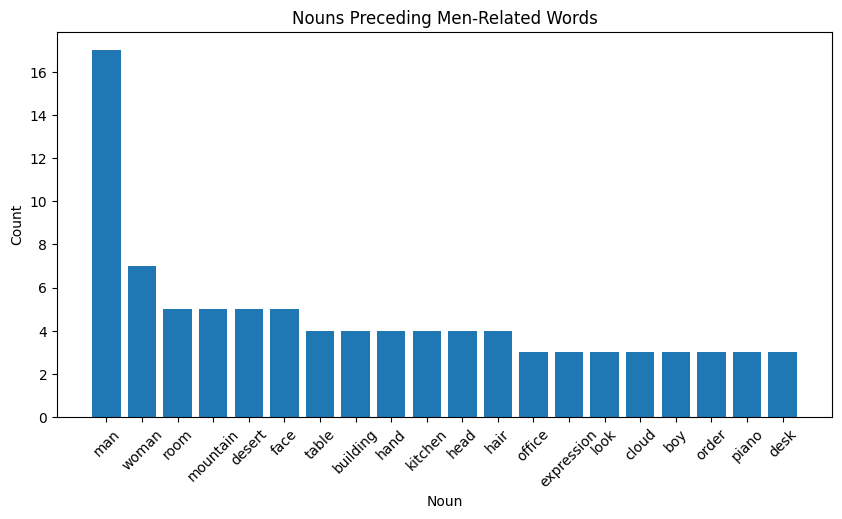

In [32]:
# Visualisation
def plot_following_nouns(counter, title):
    most_common = counter.most_common(20)
    words, counts = zip(*most_common)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel('Noun')
    plt.ylabel('Count')
    plt.show()
plot_following_nouns(women_follow_counts, 'Nouns Following Women-Related Words')
plot_following_nouns(men_follow_counts, 'Nouns Following Men-Related Words')
plot_following_nouns(women_preceding_counts, 'Nouns Preceding Women-Related Words')
plot_following_nouns(men_preceding_counts, 'Nouns Preceding Men-Related Words')

It would be interesting to look at adjectives attached to man and woman...